# Neural Network-based Protein Function Prediction

Bren Jay Magtalas, Daniel De Castro
{bcmagtalas2, ddecastro2}@up.edu.ph

In [52]:
import obonet
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

# Required for progressbar widget
import progressbar

# Exploratory Data Analysis

In [2]:
# File paths
train_go = 'Train/go-basic.obo'
train_seq = 'Train/train_sequences.fasta'
train_tax = 'Train/train_taxonomy.tsv'
train_term = 'Train/train_terms.tsv'

In [3]:
# Sample root nodes of the Gene Ontology Graph
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

In [4]:
# Parse the GO graph
graph = obonet.read_obo(train_go)

In [5]:
print(f"Number of nodes: {len(graph)}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 43248
Number of edges: 84805


In [6]:
# Sample node
term = "GO:0034655"
graph.nodes[term]

{'name': 'nucleobase-containing compound catabolic process',
 'namespace': 'biological_process',
 'def': '"The chemical reactions and pathways resulting in the breakdown of nucleobases, nucleosides, nucleotides and nucleic acids." [GOC:mah]',
 'subset': ['goslim_chembl'],
 'synonym': ['"nucleobase, nucleoside, nucleotide and nucleic acid breakdown" EXACT []',
  '"nucleobase, nucleoside, nucleotide and nucleic acid catabolic process" RELATED [GOC:dph, GOC:tb]',
  '"nucleobase, nucleoside, nucleotide and nucleic acid catabolism" EXACT []',
  '"nucleobase, nucleoside, nucleotide and nucleic acid degradation" EXACT []'],
 'is_a': ['GO:0006139',
  'GO:0019439',
  'GO:0044270',
  'GO:0046700',
  'GO:1901361']}

In [7]:
# Sample Protein sequence
print("Sequence example:\n\n", next(iter(SeqIO.parse(train_seq, 'fasta'))))

Sequence example:

 ID: P20536
Name: P20536
Description: P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosylase OS=Vaccinia virus (strain Copenhagen) OX=10249 GN=UNG PE=1 SV=1
Number of features: 0
Seq('MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLK...FIY')


In [8]:
sequences = SeqIO.parse(train_seq, "fasta")
num_sequences = sum(1 for seq in sequences)

print("Number of sequences:", num_sequences)

Number of sequences: 142246


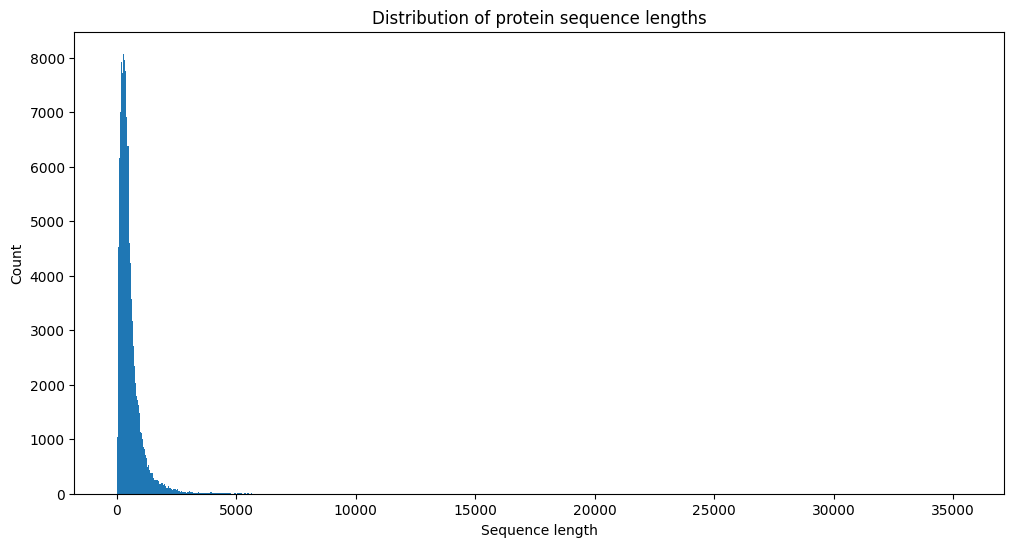

99th percentile: 2718.5499999999884


In [9]:
# Graph sequence lenth distribution
sequences = SeqIO.parse(train_seq, "fasta")
# get the length of each sequence
lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=1000)
plt.xlabel('Sequence length')
plt.ylabel('Count')
plt.title('Distribution of protein sequence lengths')
plt.show()
print(f'99th percentile: {np.percentile(lengths, 99)}')

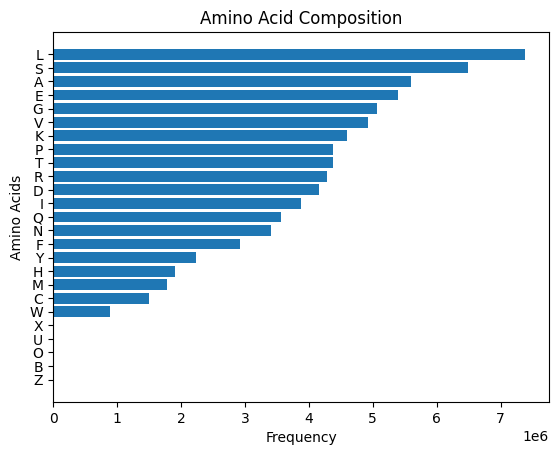

In [10]:
# Graph Amino Acid composition
sequences = SeqIO.parse(train_seq, "fasta")
amino_acids = [aa for sequence in sequences for aa in sequence.seq]
aa, aa_count = np.unique(amino_acids, return_counts=True)
sorted_index = np.argsort(aa_count)
aa_s = aa[sorted_index]
aa_count_s = aa_count[sorted_index]
plt.barh(aa_s, aa_count_s)
plt.title('Amino Acid Composition')
plt.xlabel('Frequency')
plt.ylabel('Amino Acids')
plt.show()

In [11]:
# Label terms file
train_terms_df = pd.read_csv(train_term, delimiter='\t')
train_terms_df.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [12]:
train_terms_df.describe()

,EntryID,term,aspect
count,5363863,5363863,5363863
unique,142246,31466,3
top,Q02248,GO:0005575,BPO
freq,815,92912,3497732


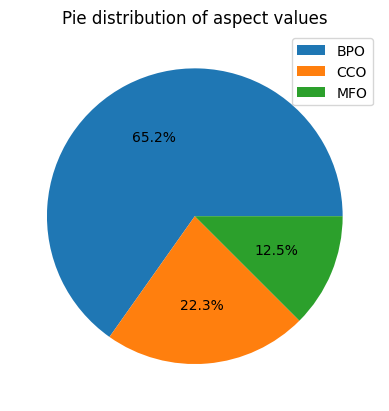

In [13]:
# Subontologies distribution
pie_data = train_terms_df.aspect.value_counts()
plt.pie(pie_data.values, autopct='%1.1f%%')
plt.legend(pie_data.index)
plt.title('Pie distribution of aspect values')
plt.show()

# Loading of Data

In [14]:
# Labels of training protein sequence
train_protein_ids = np.load('train_ids.npy')
print(train_protein_ids.shape)

(142246,)


In [15]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

In [16]:
# Vector embedding of protein sequences
train_embeddings = np.load('train_embeds.npy')

# Convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)
train_df.head()

(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


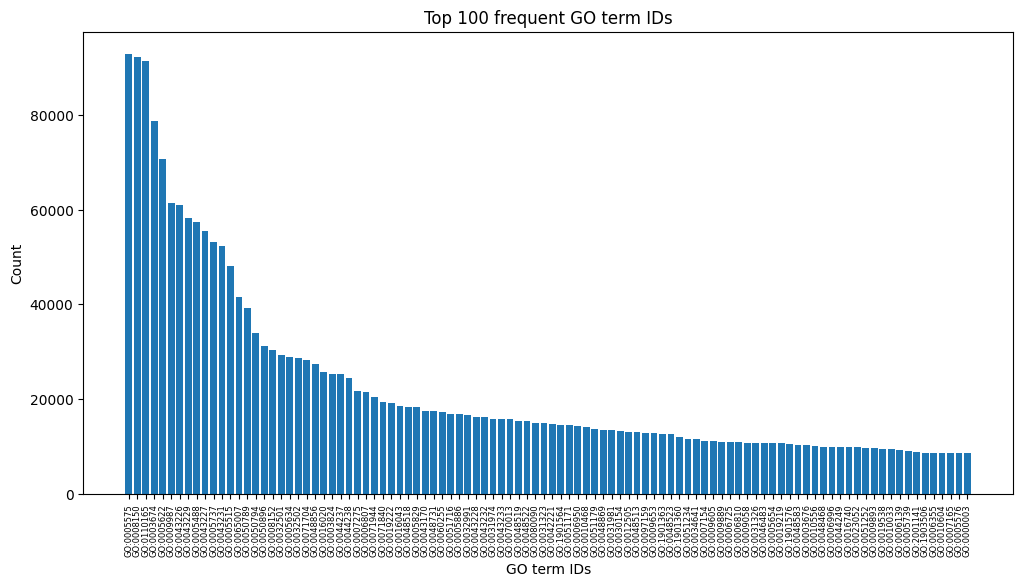

In [17]:
# Select first 1500 values for plotting
plot_df = train_terms_df['term'].value_counts().iloc[:100]
plt.figure(figsize=(12, 6))
plt.bar(np.array(plot_df.index), plot_df.values)
plt.xticks(fontsize=6, rotation=90)
plt.title('Top 100 frequent GO term IDs')
plt.xlabel("GO term IDs")
plt.ylabel("Count")
plt.show()

In [18]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms_df['term'].value_counts().index[:num_of_labels].tolist()

In [19]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms_df.loc[train_terms_df['term'].isin(labels)]

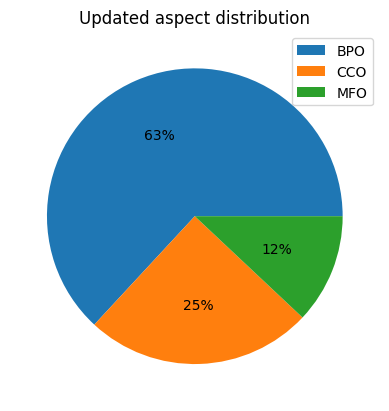

In [20]:
# New subontology distribution after getting the top 1500
pie_df = train_terms_updated['aspect'].value_counts()
plt.pie(pie_df.values, autopct='%.0f%%')
plt.legend(np.array(pie_df.index))
plt.title('Updated aspect distribution')
plt.show()

In [21]:
# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

(142246, 1500)


In [22]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have two dataframes: features_df and labels_df

# Convert the dataframes to numpy arrays
features = train_df.to_numpy()
labels_ = labels_df.to_numpy()

# Split the data into train, test, and validation sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels_, test_size=0.2, random_state=42)

train_features, val_features, train_labels, val_labels = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42)

In [ ]:
train_features.shape, test_features.shape, train_labels.shape, test_labels.shape, val_features.shape, val_labels.shape

((91036, 1024),
 (28450, 1024),
 (91036, 1000),
 (28450, 1000),
 (22760, 1024),
 (22760, 1000))

# Training

Next, we will use Tensorflow to train a Deep Neural Network with the protein embeddings.

In [ ]:
INPUT_SHAPE = [train_features.shape[1]]
BATCH_SIZE = 2000

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=2000, activation='relu'),
    tf.keras.layers.Dense(units=1000, activation='relu'),
    tf.keras.layers.Dense(units=500, activation='relu'),
    tf.keras.layers.Dense(units=2000, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    batch_size=BATCH_SIZE,
    epochs=10
)

Epoch 1/10
46/46 [==============================] - 35s 730ms/step - loss: 0.1435 - binary_accuracy: 0.9593 - auc_1: 0.7623 - val_loss: 0.5571 - val_binary_accuracy: 0.9722 - val_auc_1: 0.8407
Epoch 2/10
46/46 [==============================] - 33s 720ms/step - loss: 0.0946 - binary_accuracy: 0.9724 - auc_1: 0.8715 - val_loss: 0.5048 - val_binary_accuracy: 0.9730 - val_auc_1: 0.8901
Epoch 3/10
46/46 [==============================] - 33s 728ms/step - loss: 0.0871 - binary_accuracy: 0.9731 - auc_1: 0.9033 - val_loss: 0.4511 - val_binary_accuracy: 0.9734 - val_auc_1: 0.9087
Epoch 4/10
46/46 [==============================] - 35s 764ms/step - loss: 0.0833 - binary_accuracy: 0.9736 - auc_1: 0.9160 - val_loss: 0.4070 - val_binary_accuracy: 0.9736 - val_auc_1: 0.9176
Epoch 5/10
46/46 [==============================] - 33s 727ms/step - loss: 0.0808 - binary_accuracy: 0.9739 - auc_1: 0.9231 - val_loss: 0.3636 - val_binary_accuracy: 0.9738 - val_auc_1: 0.9232
Epoch 6/10
46/46 [=================

In [ ]:
# train for another 5 epochs
history1 = model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    batch_size=BATCH_SIZE,
    epochs=5
)

Epoch 1/5
46/46 [==============================] - 35s 773ms/step - loss: 0.0708 - binary_accuracy: 0.9759 - auc_1: 0.9453 - val_loss: 0.1165 - val_binary_accuracy: 0.9745 - val_auc_1: 0.9329
Epoch 2/5
46/46 [==============================] - 35s 768ms/step - loss: 0.0690 - binary_accuracy: 0.9764 - auc_1: 0.9486 - val_loss: 0.1021 - val_binary_accuracy: 0.9741 - val_auc_1: 0.9329
Epoch 3/5
46/46 [==============================] - 33s 718ms/step - loss: 0.0676 - binary_accuracy: 0.9768 - auc_1: 0.9510 - val_loss: 0.0908 - val_binary_accuracy: 0.9739 - val_auc_1: 0.9322
Epoch 4/5
46/46 [==============================] - 35s 774ms/step - loss: 0.0662 - binary_accuracy: 0.9771 - auc_1: 0.9534 - val_loss: 0.0833 - val_binary_accuracy: 0.9739 - val_auc_1: 0.9325
Epoch 5/5
46/46 [==============================] - 33s 727ms/step - loss: 0.0648 - binary_accuracy: 0.9775 - auc_1: 0.9557 - val_loss: 0.0805 - val_binary_accuracy: 0.9741 - val_auc_1: 0.9322


In [ ]:
# train for another 5 epochs
history2 = model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    batch_size=BATCH_SIZE,
    epochs=5
)

Epoch 1/5
46/46 [==============================] - 36s 781ms/step - loss: 0.0635 - binary_accuracy: 0.9779 - auc_1: 0.9578 - val_loss: 0.0773 - val_binary_accuracy: 0.9746 - val_auc_1: 0.9285
Epoch 2/5
46/46 [==============================] - 33s 723ms/step - loss: 0.0621 - binary_accuracy: 0.9783 - auc_1: 0.9598 - val_loss: 0.0791 - val_binary_accuracy: 0.9740 - val_auc_1: 0.9275
Epoch 3/5
46/46 [==============================] - 33s 721ms/step - loss: 0.0610 - binary_accuracy: 0.9785 - auc_1: 0.9615 - val_loss: 0.0786 - val_binary_accuracy: 0.9746 - val_auc_1: 0.9228
Epoch 4/5
46/46 [==============================] - 34s 733ms/step - loss: 0.0598 - binary_accuracy: 0.9789 - auc_1: 0.9632 - val_loss: 0.0788 - val_binary_accuracy: 0.9745 - val_auc_1: 0.9224
Epoch 5/5
46/46 [==============================] - 34s 742ms/step - loss: 0.0584 - binary_accuracy: 0.9793 - auc_1: 0.9651 - val_loss: 0.0801 - val_binary_accuracy: 0.9738 - val_auc_1: 0.9228


In [ ]:
def merge_training_histories(histories):
    merged_history = {}

    # Iterate over each history object
    for i, history in enumerate(histories):
        for key, value in history.history.items():
            # If the metric is not present in the merged_history, create a new list
            if key not in merged_history:
                merged_history[key] = []

            # Extend the list with the metric values from the current history
            merged_history[key].extend(value)

    return merged_history

In [ ]:
merged_histories = merge_training_histories([history, history1, history2])

# Plot the model's loss and accuracy for each epoch

<AxesSubplot: title={'center': 'Accuracy'}>

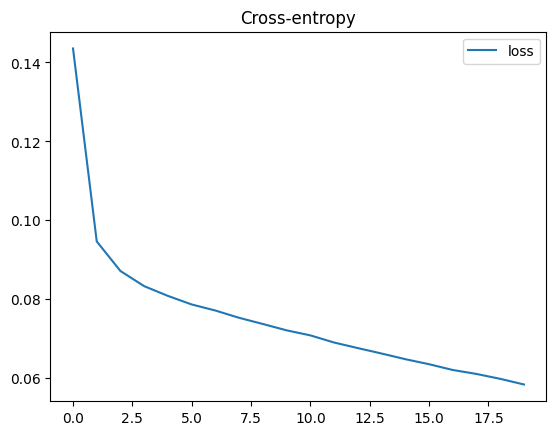

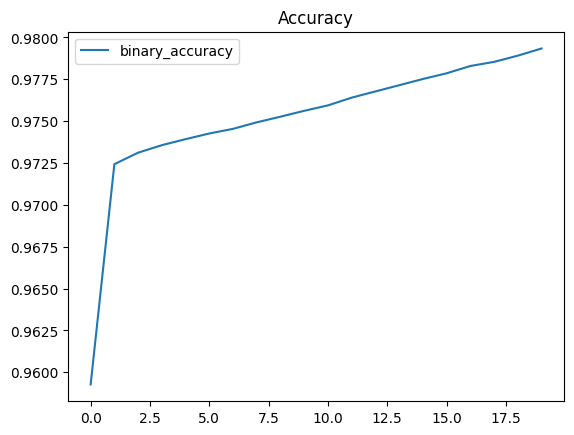

In [ ]:
history_df = pd.DataFrame(merged_histories)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

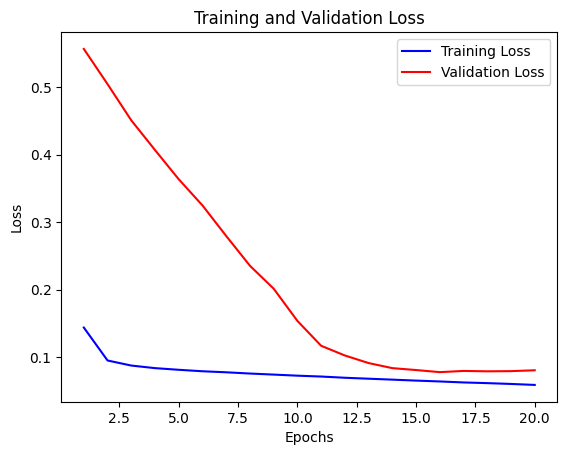

In [ ]:
# Get the training and validation loss from the history object
training_loss = merged_histories['loss']
validation_loss = merged_histories['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
metrics = model.evaluate(test_features, test_labels)
metrics

890/890 [==============================] - 13s 14ms/step - loss: 0.0808 - binary_accuracy: 0.9736 - auc_1: 0.9224


[0.08075039833784103, 0.9735996127128601, 0.922395646572113]

In [ ]:
model.save("the_model8.h5")

# Submission

For submission we will use the protein embeddings of the test data created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

In [ ]:
test_embeddings = np.load('test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


The `test_df` is composed of 1024 columns and 141865 entries. We can see all 1024 dimensions(results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [ ]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


We will now use the model to make predictions on the test embeddings. 

In [ ]:
test_protein_ids = np.load('test_ids.npy')

In [ ]:
test_protein_ids

array(['Q9CQV8', 'P62259', 'P68510', ..., 'C0HK73', 'C0HK74',
       'A0A3G2FQK2'], dtype='<U10')

In [ ]:
predictions =  model.predict(test_df)

4434/4434 [==============================] - 54s 12ms/step


In [ ]:
pd.Series(labels)[np.argsort(-predictions[1])[:20]]

8     GO:0005488
3     GO:0003674
0     GO:0005575
12    GO:0005515
2     GO:0110165
1     GO:0008150
4     GO:0005622
10    GO:0005737
5     GO:0009987
6     GO:0043226
11    GO:0043231
9     GO:0043227
7     GO:0043229
14    GO:0050789
13    GO:0065007
15    GO:0050794
23    GO:0016020
34    GO:0005829
55    GO:0051179
20    GO:0032502
dtype: object

From the predictions we will create the submission data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [ ]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")